<a href="https://colab.research.google.com/github/GowthamK2/Uber-data-analysis/blob/main/Uber_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression,LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import sys
import os
%matplotlib inline

In [4]:
def reduce_mem_usage(df):
  start_mem = df.memory_usage().sum() / 1024**2

  for col in df.columns:
    col_type = df[col].dtype
    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col] = df[col].astype(np.float16)
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df







In [5]:
cab_data = pd.read_csv('/content/cab.csv')
cab_data = reduce_mem_usage(cab_data)
weather_data = pd.read_csv('/content/weather.csv')
weather_data = reduce_mem_usage(weather_data)



Mem. usage decreased to 23.54 Mb (5.0% reduction)
Mem. usage decreased to  0.36 Mb (6.2% reduction)


In [6]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.439941,Lyft,1.544950e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.439941,Lyft,1.543280e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.439941,Lyft,1.543370e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.439941,Lyft,1.543550e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.439941,Lyft,1.543460e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [9]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [10]:
weather_data.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.40625,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43750,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50000,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.12500,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.12500,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [11]:
weather_data.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind'],
      dtype='object')

In [13]:
import datetime
cab_data['datetime'] = pd.to_datetime(cab_data['time_stamp'])
cab_data
weather_data['datetime'] = pd.to_datetime(weather_data['time_stamp'])
weather_data

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,datetime
0,42.40625,Back Bay,1.00,1012.14,0.1228,1545003901,0.77,11.25,1970-01-01 00:00:01.545003901
1,42.43750,Beacon Hill,1.00,1012.15,0.1846,1545003901,0.76,11.32,1970-01-01 00:00:01.545003901
2,42.50000,Boston University,1.00,1012.15,0.1089,1545003901,0.76,11.07,1970-01-01 00:00:01.545003901
3,42.12500,Fenway,1.00,1012.13,0.0969,1545003901,0.77,11.09,1970-01-01 00:00:01.545003901
4,43.12500,Financial District,1.00,1012.14,0.1786,1545003901,0.75,11.49,1970-01-01 00:00:01.545003901
...,...,...,...,...,...,...,...,...,...
6271,44.71875,North Station,0.89,1000.69,NaN,1543819974,0.96,1.52,1970-01-01 00:00:01.543819974
6272,44.84375,Northeastern University,0.88,1000.71,NaN,1543819974,0.96,1.54,1970-01-01 00:00:01.543819974
6273,44.81250,South Station,0.89,1000.70,NaN,1543819974,0.96,1.54,1970-01-01 00:00:01.543819974
6274,44.78125,Theatre District,0.89,1000.70,NaN,1543819974,0.96,1.54,1970-01-01 00:00:01.543819974


In [15]:
cab_data.shape

(324811, 11)

In [16]:
weather_data.shape

(6276, 9)

In [18]:
cab_data.describe()

,distance,time_stamp,price,surge_multiplier,datetime
count,324811.000000,3.248110e+05,299136.000000,324811.000000,324811
mean,2.188085,1.544039e+12,16.551972,1.014347,1970-01-01 00:25:44.039316279
min,0.020004,1.543200e+12,2.500000,1.000000,1970-01-01 00:25:43.200000
25%,1.269531,1.543440e+12,9.000000,1.000000,1970-01-01 00:25:43.440000
50%,2.150391,1.543730e+12,13.500000,1.000000,1970-01-01 00:25:43.730000
75%,2.929688,1.544820e+12,22.500000,1.000000,1970-01-01 00:25:44.820000
max,7.621094,1.545160e+12,92.000000,3.000000,1970-01-01 00:25:45.160000
std,1.139947,6.885418e+08,9.346019,0.093384,NaN


In [19]:
weather_data.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind,datetime
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000,6276
mean,39.090527,0.677777,1008.445209,0.057652,1.543857e+09,0.763985,6.802812,1970-01-01 00:00:01.543857377
min,19.625000,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000,1970-01-01 00:00:01.543203644
25%,36.085938,0.440000,997.747500,0.004900,1.543387e+09,0.670000,3.517500,1970-01-01 00:00:01.543386870
50%,40.125000,0.780000,1007.660000,0.014850,1.543514e+09,0.760000,6.570000,1970-01-01 00:00:01.543513974
75%,42.843750,0.970000,1018.480000,0.060925,1.544691e+09,0.890000,9.920000,1970-01-01 00:00:01.544690701
max,55.406250,1.000000,1035.120000,0.780700,1.545159e+09,0.990000,18.180000,1970-01-01 00:00:01.545158702
std,6.022037,0.314284,12.870775,0.100758,6.659340e+05,0.127340,3.633466,NaN


In [20]:
a = pd.concat([cab_data,weather_data])

In [22]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind
0,0.439941,Lyft,1.544950e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.439941,Lyft,1.543280e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.439941,Lyft,1.543370e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.439941,Lyft,1.543550e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.439941,Lyft,1.543460e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
a['day'] = a.datetime.dt.day
a['hour'] = a.datetime.dt.hour
a['month'] = a.datetime.dt.month
a['year'] = a.datetime.dt.year
a['minute'] = a.datetime.dt.minute
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,clouds,pressure,rain,humidity,wind,day,hour,month,year,minute
0,0.439941,Lyft,1.544950e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,NaN,NaN,NaN,NaN,NaN,1,0,1,1970,25
1,0.439941,Lyft,1.543280e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,NaN,NaN,NaN,NaN,NaN,1,0,1,1970,25
2,0.439941,Lyft,1.543370e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,NaN,NaN,NaN,NaN,NaN,1,0,1,1970,25
3,0.439941,Lyft,1.543550e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,NaN,NaN,NaN,NaN,NaN,1,0,1,1970,25
4,0.439941,Lyft,1.543460e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,NaN,NaN,NaN,NaN,NaN,1,0,1,1970,25


In [24]:
a.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,clouds,pressure,rain,humidity,wind,day,hour,month,year,minute
6271,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.89,1000.69,NaN,0.96,1.52,1,0,1,1970,0
6272,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.88,1000.71,NaN,0.96,1.54,1,0,1,1970,0
6273,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.89,1000.70,NaN,0.96,1.54,1,0,1,1970,0
6274,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.89,1000.70,NaN,0.96,1.54,1,0,1,1970,0
6275,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.89,1000.70,NaN,0.96,1.52,1,0,1,1970,0


In [25]:
a.fillna(0,inplace=True)

In [26]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,clouds,pressure,rain,humidity,wind,day,hour,month,year,minute
0,0.439941,Lyft,1.544950e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,0.0,0.0,0.0,0.0,0.0,1,0,1,1970,25
1,0.439941,Lyft,1.543280e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,0.0,0.0,0.0,0.0,0.0,1,0,1,1970,25
2,0.439941,Lyft,1.543370e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,0.0,0.0,0.0,0.0,0.0,1,0,1,1970,25
3,0.439941,Lyft,1.543550e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,0.0,0.0,0.0,0.0,0.0,1,0,1,1970,25
4,0.439941,Lyft,1.543460e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,0.0,0.0,0.0,0.0,0.0,1,0,1,1970,25


In [27]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'day',
       'hour', 'month', 'year', 'minute'],
      dtype='object')

In [28]:
a.groupby('cab_type').count()

,distance,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,...,clouds,pressure,rain,humidity,wind,day,hour,month,year,minute
cab_type,,,,,,,,,,,,,,,,,,,,,
0,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,...,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276
Lyft,145038,145038,145038,145038,145038,145038,145038,145038,145038,145038,...,145038,145038,145038,145038,145038,145038,145038,145038,145038,145038
Uber,179773,179773,179773,179773,179773,179773,179773,179773,179773,179773,...,179773,179773,179773,179773,179773,179773,179773,179773,179773,179773


<Axes: xlabel='cab_type'>

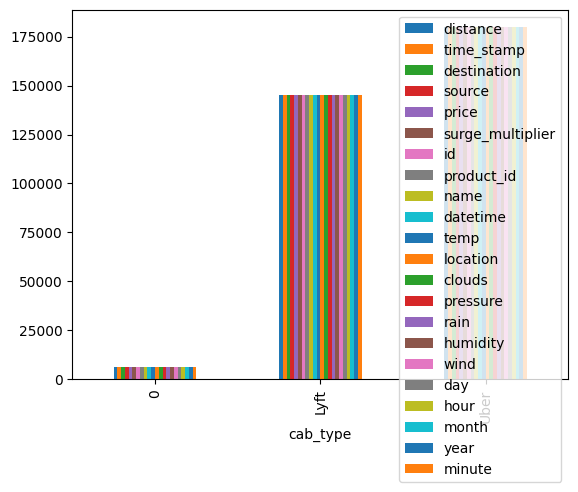

In [29]:
a.groupby('cab_type').count().plot.bar()

<Axes: xlabel='price'>

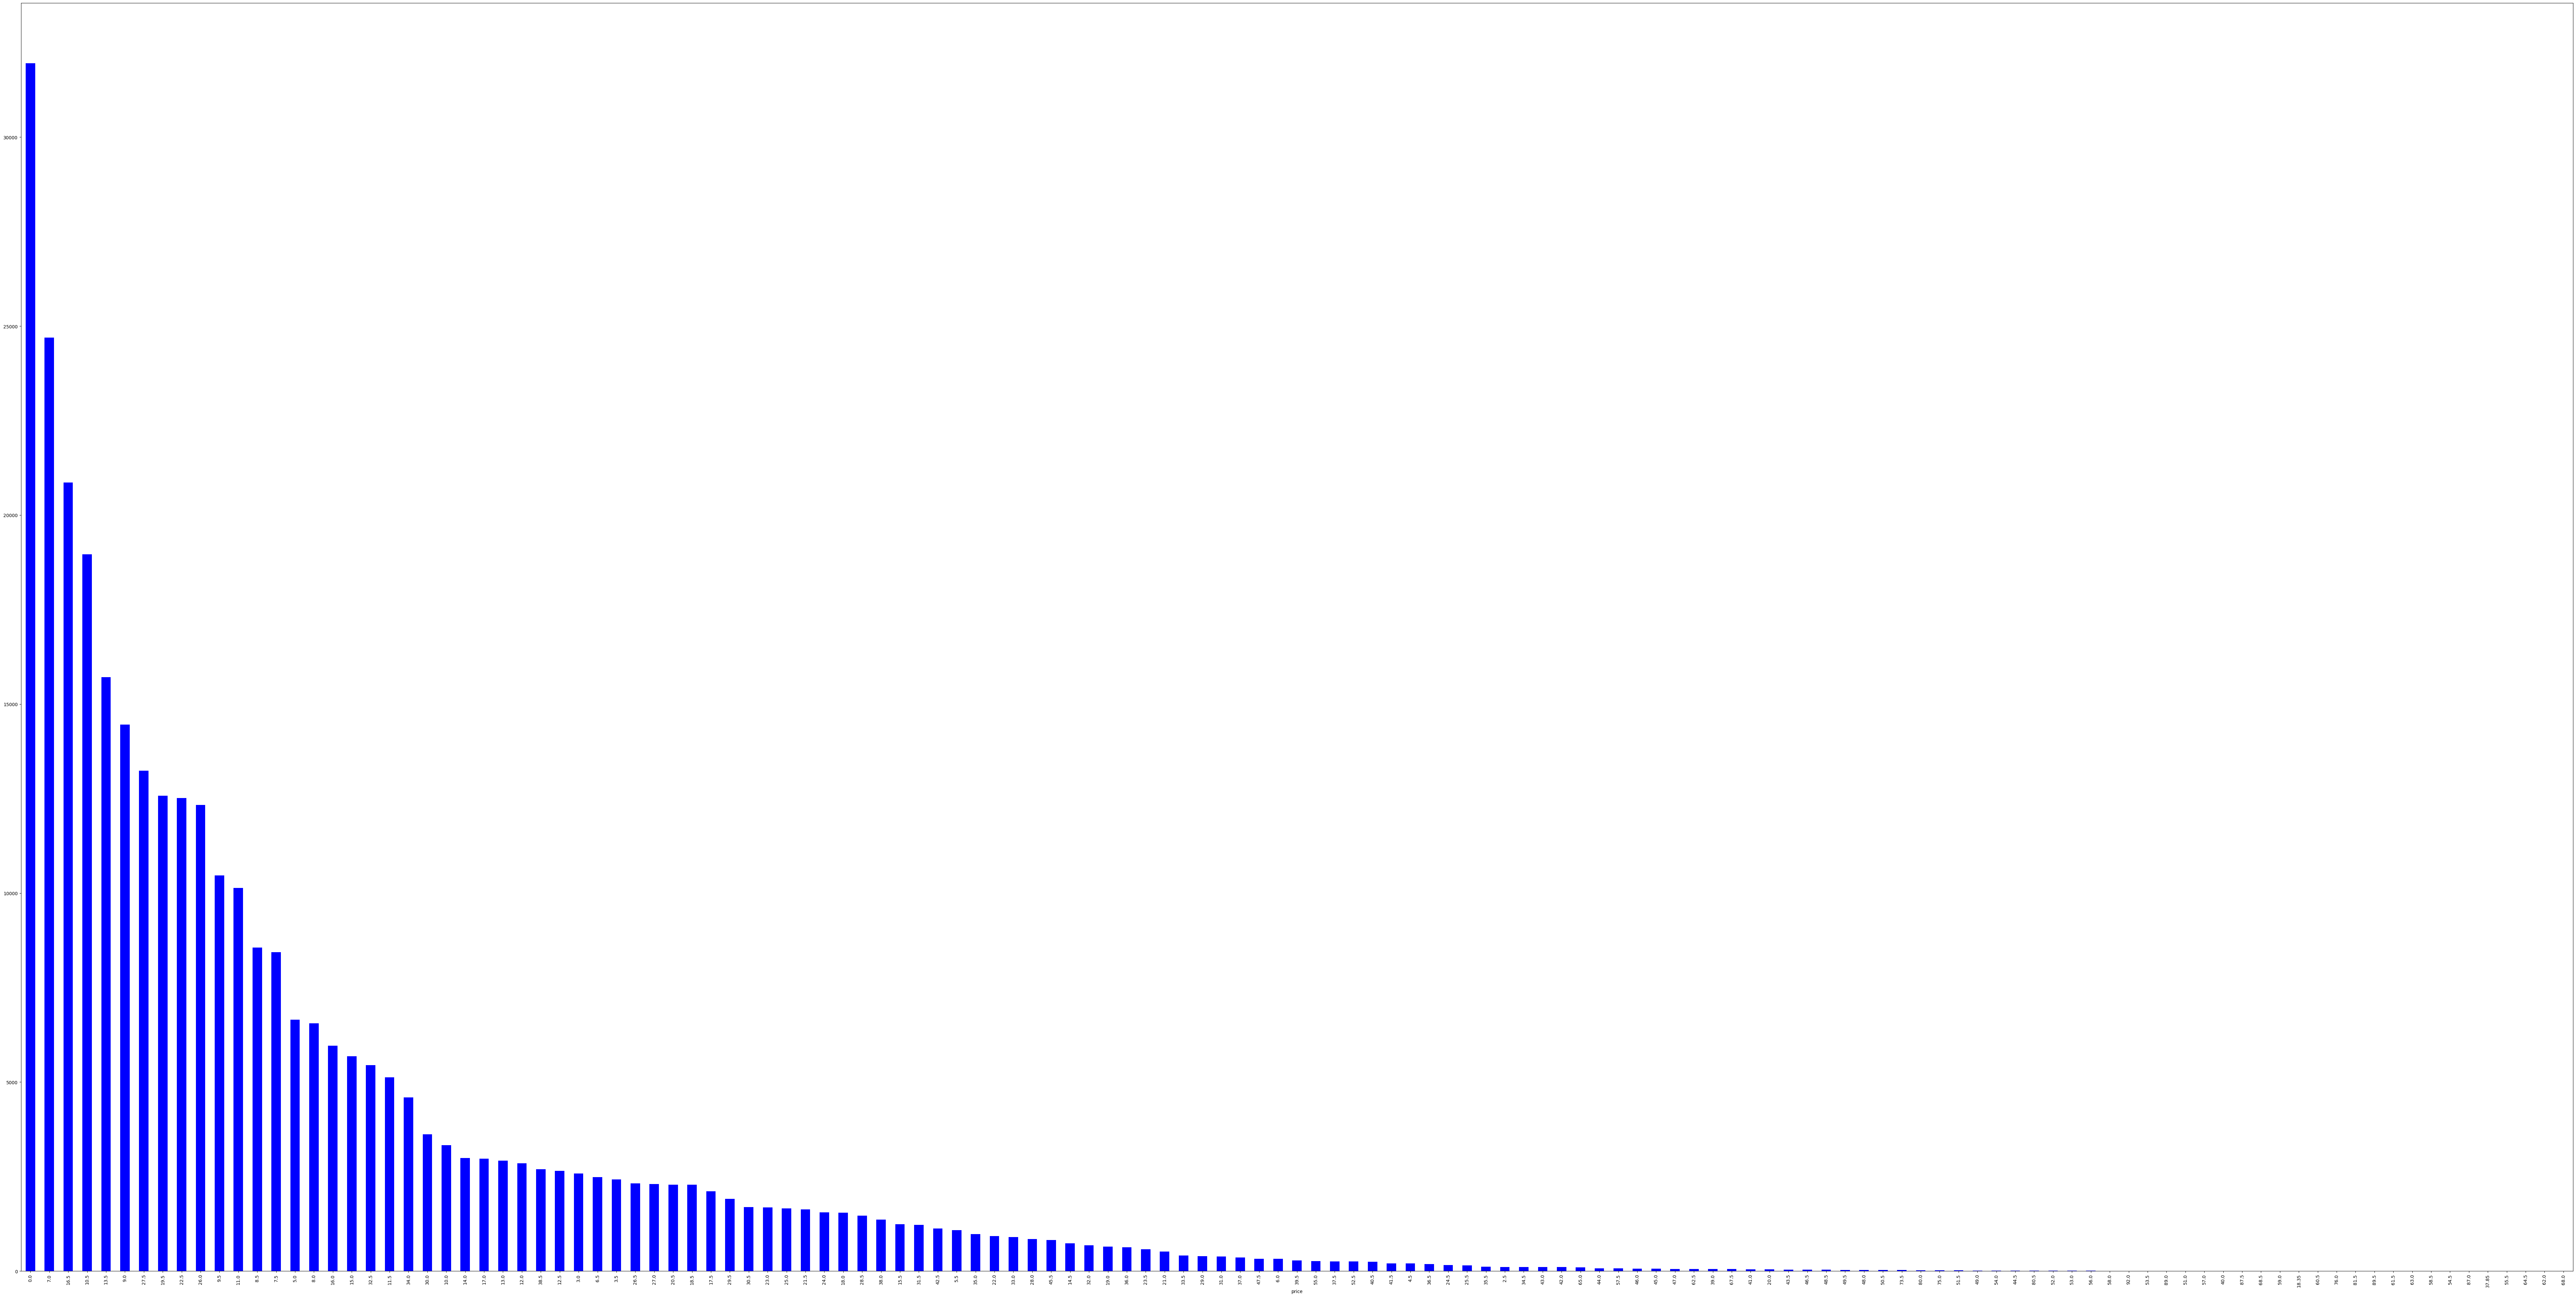

In [30]:
a['price'].value_counts().plot(kind='bar',figsize=(100,50),color = 'blue')

<Axes: xlabel='hour'>

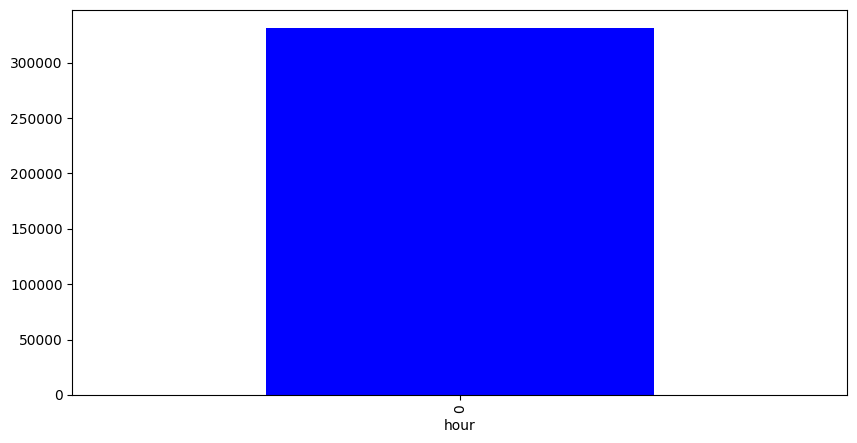

In [33]:
a['hour'].value_counts().plot(kind='bar',figsize=(10,5),color = 'blue')

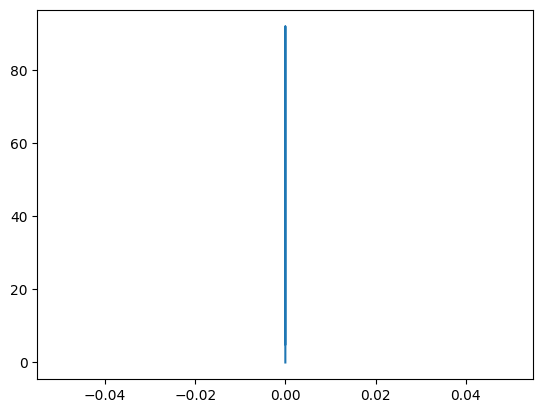

In [36]:
import matplotlib.pyplot as plt
x = a['hour']
y = a['price']
plt.plot(x,y)
plt.show()


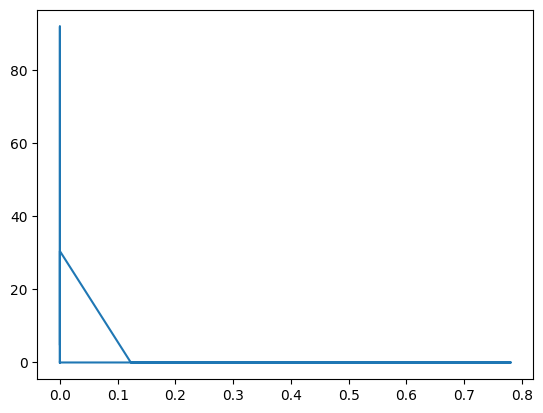

In [37]:
import matplotlib.pyplot as plt
x = a['rain']
y = a['price']
plt.plot(x,y)
plt.show()

In [38]:
x1 = a[['distance','temp','clouds','rain','pressure','day','wind','humidity','hour','month','year','minute']]
y1 = a['price']


In [42]:
from sklearn.model_selection import train_test_split
x_train,y_train,x_test,y_test = train_test_split(x1,y1,test_size = 0.25,random_state = 42)

In [44]:
linear = LinearRegression()
linear.fit(x_train,x_test)

LinearRegression()

In [45]:
prediction = linear.predict(y_train)
prediction

array([25.87028835, 13.45374327, 10.95057185, ..., 15.5418415 ,
       12.54211014, 16.63681984])

In [48]:
df = pd.DataFrame({'Actual':y_test,'predicted':prediction})
df

,Actual,predicted
78632,0.0,25.870288
269759,8.0,13.453743
86505,11.0,10.950572
164402,16.5,28.997343
24221,19.5,16.402545
...,...,...
70505,22.5,15.903439
99723,8.5,15.592771
294352,9.5,15.541841
46495,7.0,12.542110


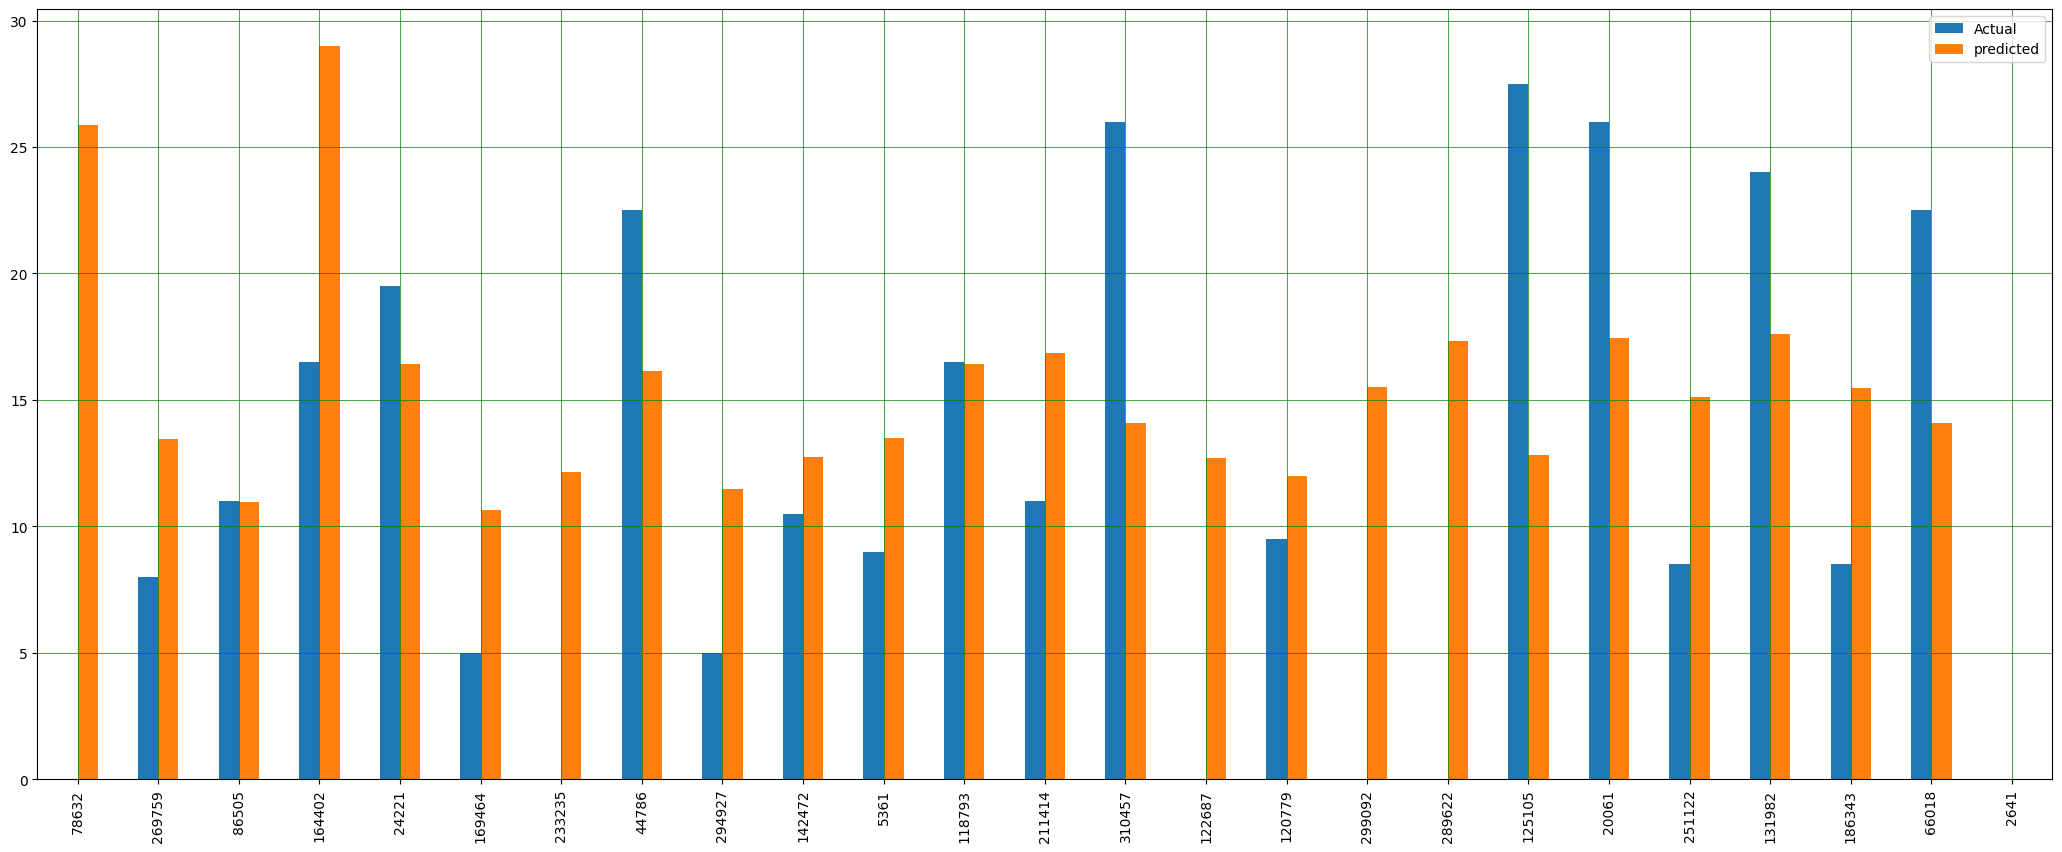

In [50]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(26,10))
plt.grid(which='major',linestyle='-',linewidth='0.5',color='green')
plt.grid(which='minor',linestyle=':',linewidth='0.5',color='black')
plt.show()